<a href="https://colab.research.google.com/github/gabrielmprata/Anatel_Reclamacoes/blob/main/Anatel_Reclamacoes_PreProc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img loading="lazy" src="https://cdn.jsdelivr.net/gh/devicons/devicon@latest/icons/python/python-original.svg" width="40" height="40"/> <img src="https://cdn.jsdelivr.net/gh/devicons/devicon@latest/icons/pandas/pandas-original-wordmark.svg" width="40" height="40"/>   <img loading="lazy" src="https://cdn.jsdelivr.net/gh/devicons/devicon@latest/icons/plotly/plotly-original-wordmark.svg" width="40" height="40"/>

---
**Pré Processamento de dados**
>
**Dev**: Gabriel Prata
>
**Data**: 03/09/2024
>
**Última modificação**: 09/09/2024
>
**Contexto**: *Anatel - Reclamações*
>
---

![Badge em Desenvolvimento](http://img.shields.io/static/v1?label=STATUS&message=Desenvolvimento&color=FFF666&style=for-the-badge)

#**<font color=#FFF666 size="6"> Import libraries**

In [4]:
# Importação de pacotes
import pandas as pd
import numpy as np
import missingno as ms # para tratamento de missings
import datetime
import re # expressão regulares

#bibliotecas para visualização de dados
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")


#**<font color=#fff666 size="6"> 1. Objetivo**

Esse Notebook, foca na etapa de pré-processamento de dados.
>
Esta é a etapa mais demorada e trabalhosa do projeto de ciência de dados, e estima-se que consuma pelo menos 70% do tempo total do projeto.
>
Ao final desse notebook, entregaremos um arquivo mais coeso para as análises dos dados das reclamações feitas pelos usuários de telefonia a Anatel.

#**<font color=#fff666 size="6"> 2. Coleta de dados**

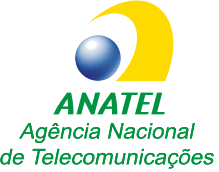
>
As informações das **Reclamações registradas**, estão no sítio de dados abertos da Anatel, no link abaixo:
>
https://dados.gov.br/dados/conjuntos-dados/solicitacoesregistradasnaanatel
>

No link acima, é disponibilizado um arquivo compactado *consumidor_reclamacoes.zip*, com ceraga de 520 mega bytes.
>
Ao descompactar, usamos nesse projeto o arquivo, *reclamacoes_contexto.csv*, com cerca de 3,8 Gigabytes.
>
É um arquivo muito grande para manipular no Colab, sendo assim desenvolvi um código Python no VsCode, usando os recursos da minha máquina, para importar o arquivo, e gerar um arquivo compactado para poder utilizar com mais facilidade e agilidade.
>
Link para o arquivo .py
>
[<img loading="lazy" src="https://cdn.jsdelivr.net/gh/devicons/devicon@latest/icons/github/github-original-wordmark.svg" width="40" height="40"/>](https://github.com/gabrielmprata/Anatel_Reclamacoes/blob/main/Pre_etl.py)

###**<font color=#fff666> 2.1 Importando arquivo**

In [5]:
url   = "https://raw.githubusercontent.com/gabrielmprata/Anatel_Reclamacoes/main/datasets/df_anatel_rec.csv.bz2"

df_anatel = pd.read_csv(url, encoding = "Latin 1", sep=';')

In [ ]:
# Valida carga
df_anatel.head(2)

,Ano,Mês,AnoMês,UF,CanalEntrada,Condição,TipoAtendimento,Serviço,Marca,Assunto,Problema,SOLICITAÇÕES
0,2015,1,2015-01,,Atendimento Pessoal,Nova,Reclamação,SCM,OI,Qualidade e Funcionamento do Serviço ou Equipa...,Lentidão ou velocidade reduzida de conexão,1
1,2015,1,2015-01,,Call Center,Nova,Reclamação,SCM,OI,Atendimento,"Fornecimento de informações divergentes, incom...",1


####**<font color=#fff666> 2.2 Municípios IBGE API**

Iremos utilizar a API do IBGE, para coletar todos os códigos dos municípios brasileiros.
>
Essas informações, irão enriquecer o Dataset com o nome do município, estado e a unidade da federação.

In [ ]:
pip install ibge

In [ ]:
# Importando os pacotes da biblioteca de localidades
from ibge.localidades import *

In [ ]:
# Função Municipios() retorna um objeto do tipo ibge.localidades.Estados

dados = Estados()

In [ ]:
type(dados)

ibge.localidades.Estados

In [ ]:
regiao = dados.json()

In [ ]:
#pandas json_normalize ler a string JSON aninhada e devolver um DataFrame.
regiao_br = pd.json_normalize(regiao)

In [ ]:
regiao_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            27 non-null     int64 
 1   sigla         27 non-null     object
 2   nome          27 non-null     object
 3   regiao.id     27 non-null     int64 
 4   regiao.sigla  27 non-null     object
 5   regiao.nome   27 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.4+ KB


In [ ]:
#excluir as colunas que não iremos utilizar
regiao_br.drop(['id','nome', 'regiao.id', 'regiao.sigla'], axis=1, inplace = True)

In [ ]:
#renomear colunas
regiao_br = regiao_br.rename(columns={'sigla': 'uf',
                                'regiao.nome': 'regiao'
                                })

In [ ]:
regiao_br.head()

,uf,regiao
0,RO,Norte
1,AC,Norte
2,AM,Norte
3,RR,Norte
4,PA,Norte


#**<font color=#fff666 size="6"> 3. Análise de Dados Inicial**

###**<font color=#fff666> 3.1. Estatísticas Descritivas**

Compreende a organização, o resumo e, descrever os dados, que podem ser expressos em tabelas e gráficos.
>
Veremos a seguir alguns comandos para exibir algumas estatísticas descritivas.
>
---

In [ ]:
#	Quantidade de atributos e instâncias (linhas/colunas)
df_anatel.shape

(1222823, 12)

<font color=#fff666> Dataframe com 12 atributos(features) e 1.2MM tuplas.


In [ ]:
# Exibir os 5 primeiros registros
df_anatel.head(5)

,Ano,Mês,AnoMês,UF,CanalEntrada,Condição,TipoAtendimento,Serviço,Marca,Assunto,Problema,SOLICITAÇÕES
0,2015,1,2015-01,,Atendimento Pessoal,Nova,Reclamação,SCM,OI,Qualidade e Funcionamento do Serviço ou Equipa...,Lentidão ou velocidade reduzida de conexão,1
1,2015,1,2015-01,,Call Center,Nova,Reclamação,SCM,OI,Atendimento,"Fornecimento de informações divergentes, incom...",1
2,2015,1,2015-01,,Call Center,Nova,Reclamação,SCM,OI,Bloqueio ou Suspensão e Desbloqueio,Bloqueio ou suspensão indevido,1
3,2015,1,2015-01,,Call Center,Nova,Reclamação,SCM,OI,Cobrança,"Cobrança de serviço, produto ou plano não cont...",1
4,2015,1,2015-01,,Call Center,Nova,Reclamação,SCM,OI,Cobrança,Cobrança indevida de multa por fidelização (mu...,1


In [ ]:
# Mostra diversas informações do Dataframe em um único comando, e exibir o uso de memória
df_anatel.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222823 entries, 0 to 1222822
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   Ano              1222823 non-null  int64 
 1   Mês              1222823 non-null  int64 
 2   AnoMês           1222823 non-null  object
 3   UF               1222823 non-null  object
 4   CanalEntrada     1222823 non-null  object
 5   Condição         1222823 non-null  object
 6   TipoAtendimento  1222823 non-null  object
 7   Serviço          1222823 non-null  object
 8   Marca            1222823 non-null  object
 9   Assunto          1222823 non-null  object
 10  Problema         1222823 non-null  object
 11  SOLICITAÇÕES     1222823 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 838.6 MB


<font color=#fff666> Data frame utilizando 838 MB de memória.

In [ ]:
# Quantidade de valores únicos
df_anatel.nunique()

,0
Ano,10
Mês,12
AnoMês,115
UF,28
CanalEntrada,12
Condição,3
TipoAtendimento,1
Serviço,1
Marca,21
Assunto,23


In [ ]:
# Quantidade de NaN/Missing/Nulls no dataframe
df_anatel.isnull().sum()

,0
Ano,0
Mês,0
AnoMês,0
UF,0
CanalEntrada,0
Condição,0
TipoAtendimento,0
Serviço,0
Marca,0
Assunto,0


###**<font color=#fff666> 3.2. Distribuição dos atributos**

>Nessa etapa, iremos verificar a distribuição dos principais atributos. Para ver se existe a necessidade de tomar alguma ação de transformações na etapa de preparação de dados.


---

In [ ]:
df_anatel.describe().round(2)

,Ano,Mês,SOLICITAÇÕES
count,1222823.00,1222823.00,1222823.00
mean,2019.50,6.33,4.27
std,2.66,3.41,16.98
min,2015.00,1.00,1.00
25%,2017.00,3.00,1.00
50%,2020.00,6.00,1.00
75%,2022.00,9.00,3.00
max,2024.00,12.00,1894.00


In [ ]:
df_anatel.CanalEntrada.value_counts() #quantidade

,count
CanalEntrada,
Call Center,406142
Usuário WEB,264291
Fale Conosco,227175
Mobile App,209771
Aplicativo Móvel,109229
Atendimento Pessoal,4697
SEI,1225
Correspondência,252
TTS,32


In [ ]:
df_anatel.Condição.value_counts() #quantidade

,count
Condição,
Nova,915026
Reaberta,274485
Reencaminhada,33312


In [ ]:
df_anatel.Assunto.value_counts() #quantidade

,count
Assunto,
Cobrança,352060
"Qualidade, Funcionamento e Reparo",249809
Cancelamento,127138
Instalação ou Ativação ou Habilitação,84492
Atendimento,84207
"Plano de serviços, Oferta, Bônus, Promoções e Mensagens Publicitárias",63928
"Oferta, Bônus, Promoções, Mensagens Publicitárias e Mudança de Plano",44179
Ressarcimento,36267
Mudança de Endereço,36109


Alguns assuntos podem ser agrupados, pois tratam do mesmo problema específico.
>
Segue os agrupamentos, que seram modificados na etapa apropriada desse projeto:


1. Bloqueio ou Suspensão e Desbloqueio
1. Bloqueio, desbloqueio ou Suspensão
>
2. Dados Cadastrais
3. Dados cadastrais e número da linha
4. Dados cadastrais ou número da linha
>
5. Documento de Cobrança, Contrato, Gravações
6. Documento de Cobrança, Contrato, Relatório, Gravações
>
8. Mudança de Plano
9. Oferta
9. Oferta, Bônus, Promoções, Mensagens Publicitárias e  Mudança de Plano
9. Plano de serviços, Oferta, Bônus, Promoções e Mensagens Publicitárias
9. Bônus e Promoções
>
9. Qualidade e Funcionamento do Serviço ou Equipamento
9. Qualidade, Funcionamento e Reparo
>
9. Cancelamento
9. Dificuldade em cancelar





#**<font color=#fff666 size="6"> 4. Pré-Processamento de dados**

Após coletar e analisar os dados na etapa anterior, agora é o momento
de limpar, transformar e apresentar melhor os dados.
>
Assim poderemos obter, na próxima etapa, os melhores resultados possíveis nos algoritmos de
Machine Learning, ou simplesmente apresentar dados mais confiáveis para os clientes em soluções de
business intelligence.


---

###**<font color=#fff666> 4.1. Limpeza**

####**<font color=#fff666> 4.1.1 Padronização de dados**

Dentro da programação, possuímos alguns padrões de escrita para nomes de variáveis, funções, classes e assim por diante.
>
Esses padrões de escrita são chamados de estilos de case.
>
Existem diversos tipos de case, nesse projeto iremos utilizar:
>
**Snake Case (snake_case)**: Nesse estilo, todas as letras são minúsculas e as palavras são separadas por um underscore(_).

In [6]:
# Criar uma função para aplicar o snake_case
def snake_case(string):
    string = re.sub(" +", " ", string)   # substitui múltiplos espaços por um espaço
    string = re.sub(" ", "_", string)    # substitui espaço por _
    return string.lower() # transforma em minuscula

df_anatel.columns = [snake_case(column) for column in df_anatel.columns]
df_anatel.columns

Index(['ano', 'mês', 'anomês', 'uf', 'canalentrada', 'condição',
       'tipoatendimento', 'serviço', 'marca', 'assunto', 'problema',
       'solicitações'],
      dtype='object')

In [7]:
#renomear colunas
df_anatel = df_anatel.rename(columns={'mês': 'mes',
                                      'anomês': 'anomes',
                                      'condição': 'condicao',
                                      'serviço': 'servico',
                                      'solicitações': 'qtd'
                                })

In [8]:
df_anatel.columns

Index(['ano', 'mes', 'anomes', 'uf', 'canalentrada', 'condicao',
       'tipoatendimento', 'servico', 'marca', 'assunto', 'problema', 'qtd'],
      dtype='object')

####**<font color=#fff666> 4.1.2 Redundâncias**

In [9]:
df_anatel.loc[df_anatel.assunto=='Bloqueio ou Suspensão e Desbloqueio','assunto']='Bloqueio, desbloqueio ou Suspensão'

df_anatel.loc[df_anatel.assunto=='Dados cadastrais e número da linha','assunto']='Dados Cadastrais'
df_anatel.loc[df_anatel.assunto=='Dados cadastrais ou número da linha','assunto']='Dados Cadastrais'

df_anatel.loc[df_anatel.assunto=='Documento de Cobrança, Contrato, Gravações','assunto']='Documento de Cobrança, Contrato, Relatório, Gravações'

df_anatel.loc[df_anatel.assunto=='Mudança de Plano','assunto']='Oferta, Bônus, Promoções, Mensagens Publicitárias e Mudança de Plano'
df_anatel.loc[df_anatel.assunto=='Oferta','assunto']='Oferta, Bônus, Promoções, Mensagens Publicitárias e Mudança de Plano'

df_anatel.loc[df_anatel.assunto=='Plano de serviços, Oferta, Bônus, Promoções e Mensagens Publicitárias','assunto']='Oferta, Bônus, Promoções, Mensagens Publicitárias e Mudança de Plano'
df_anatel.loc[df_anatel.assunto=='Bônus e Promoções','assunto']='Oferta, Bônus, Promoções, Mensagens Publicitárias e Mudança de Plano'

df_anatel.loc[df_anatel.assunto=='Qualidade e Funcionamento do Serviço ou Equipamento','assunto']='Qualidade, Funcionamento e Reparo'

df_anatel.loc[df_anatel.assunto=='Dificuldade em cancelar','assunto']='Cancelamento'

In [10]:
df_anatel.groupby(["assunto"])['qtd'].sum().reset_index()

,assunto,qtd
0,Atendimento,193444
1,"Bloqueio, desbloqueio ou Suspensão",173870
2,Cancelamento,442965
3,Cobrança,1461821
4,Dados Cadastrais,30446
5,"Documento de Cobrança, Contrato, Relatório, Gr...",35025
6,Instalação ou Ativação ou Habilitação,404144
7,Mudança de Endereço,115661
8,"Oferta, Bônus, Promoções, Mensagens Publicitár...",275846
9,Programa Banda Larga nas Escolas (PBLE),872


###**<font color=#fff666> 4.2. Enriquecimento**

Existem outros atributos que iremos relacionar com outro dataset.
>
Seria como um modelo relacional, porém nesse caso, iremos adicionar no dataset principal(Fato), os atributos das dimensões.

In [ ]:
df_anatel = pd.merge(df_anatel, regiao_br, left_on=['uf'], right_on=['uf'], how='left')

#**<font color=#fff666 size="6"> 5. Export**

In [ ]:
from shutil import copyfileobj
import bz2

# Exportar para csv
df_anatel.to_csv('df_anatel.csv', index=False)

# compactar arquivo com nivel de compressão máxima
with open('df_anatel.csv', 'rb') as input:
    with bz2.BZ2File('df_anatel.csv.bz2', 'wb', compresslevel=9) as output:
        copyfileobj(input, output)